# Graph
Force-directed graph layout. For a bigger example, see https://brundling.neocities.org/

In [1]:
%autosave 0

from tools import *
from graph import Graph
from plot import Plot

plot = Plot(figsize=(4, 4))

Autosave disabled


## build a Graph

Input an iterable of (source, target) pairs.

In [2]:
graph = dict()
graph['alice'] = ['bob', 'carol']
graph['bob'] = ['carol', 'alice']
graph['carol'] = ['alice']
graph['dave'] = ['eve']
graph = Graph( (k, x) for k, v in graph.items() for x in v )
graph.links

,source,target,weight
0,alice,bob,1
1,alice,carol,1
2,bob,alice,1
3,bob,carol,1
4,carol,alice,1
5,dave,eve,1


In [3]:
graph.nodes

Index(['alice', 'bob', 'carol', 'dave', 'eve'], dtype='object')

## build a sparse matrix

In [4]:
graph.matrix

<5x5 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [5]:
graph.matrix.toarray()

array([[0, 1, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]], dtype=int64)

## iterate over a Graph

In [6]:
list(graph)

[Link(source='alice', target='bob', weight=1),
 Link(source='alice', target='carol', weight=1),
 Link(source='bob', target='alice', weight=1),
 Link(source='bob', target='carol', weight=1),
 Link(source='carol', target='alice', weight=1),
 Link(source='dave', target='eve', weight=1)]

## build a weighted Graph
Input an iterable of (source, target, weight) triples

In [7]:
Graph( (s, t, 3*w) for s,t,w in graph )

Graph with 6 links
  source target  weight
0  alice    bob       3
1  alice  carol       3
2    bob  alice       3
3    bob  carol       3
4  carol  alice       3
5   dave    eve       3

## calculate layout

In [8]:
graph.frame(100)

,x,y
alice,-0.553980,-0.089244
bob,-0.197290,-0.112430
carol,-0.461111,0.375296
dave,0.559741,0.197248
eve,0.688546,-0.321247


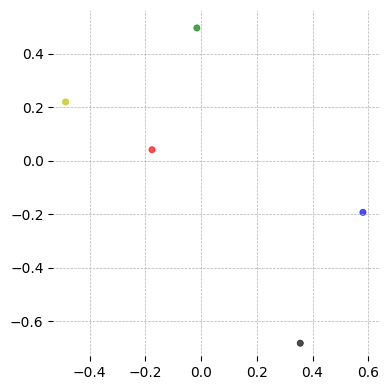

In [9]:
frame = graph.frame()
frame['color'] = list('rygbk')
plot.scatter(frame)

## show layout steps

In [10]:
data = DataFrame(index=graph.nodes)
data['x'] = data['y'] = 0
data['color'] = list('rygbk')
data

,x,y,color
alice,0,0,r
bob,0,0,y
carol,0,0,g
dave,0,0,b
eve,0,0,k


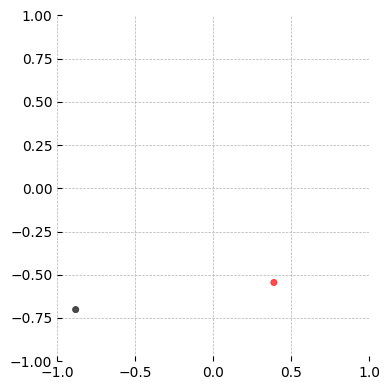

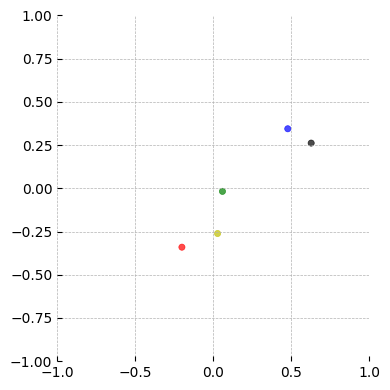

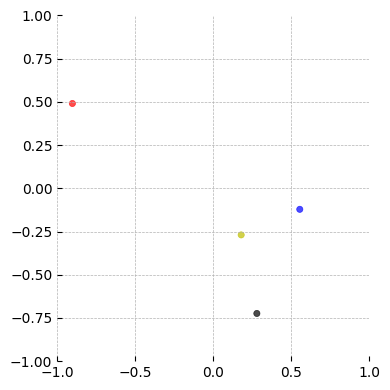

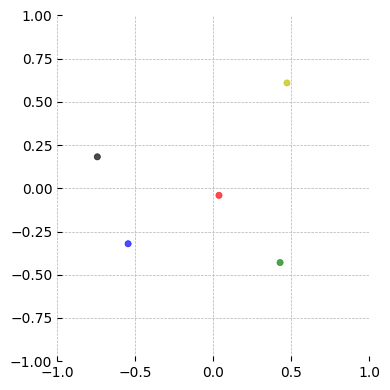

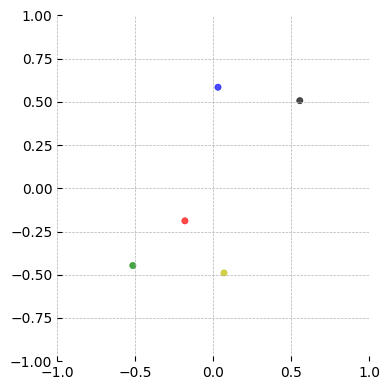

In [11]:
points = enumerate(graph(100))
points = ( z for i, z in points if not i % 20 )
for x, y in points:
    data['x'] = x
    data['y'] = y
    axes = plot.scatter(data, xlim=(-1, 1), ylim=(-1, 1))

## help

In [12]:
help(Graph)

Help on class Graph in module graph:

class Graph(builtins.object)
 |  Graph(graph)
 |  
 |  Force-directed graph layout based on Gephi's ForceAtlas2 model.
 |  
 |  Initialize with any valid DataFrame input with 2 or 3 columns.
 |  Graph stores links as a DataFrame with 3 columns: source, target, weight.
 |  If input has 2 columns, then each row is assigned weight 1.
 |  Weights for duplicated (node, node) pairs are summed.
 |  
 |  Call with a number of timesteps to return two NumPy arrays (x, y).
 |  Call accepts optional starting coordinates as 'x', 'y' keyword arguments.
 |  Coordinates are typically, but not always, in the range [-1, 1].
 |  
 |  Iterating over a Graph returns rows as namedtuples.
 |  
 |  Methods defined here:
 |  
 |  __call__(self, nsteps, x=(), y=())
 |      Call self as a function.
 |  
 |  __init__(self, graph)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  __len__(self)
 |  
 |  __repr__(self)
 |    